Data Summary:

Number of instances: 1460
Number of features: 81
Number of categorical features: 43
Number of numerical features: 38

----------------------------------------------------

Correlation between OverallQual and SalePrice: 0.80
Correlation between GrLivArea and SalePrice: 0.71
Correlation between GarageCars and SalePrice: 0.65
Correlation between GarageArea and SalePrice: 0.62
Correlation between TotalBsmtSF and SalePrice: 0.62

----------------------------------------------------

Number of features with missing values: 19
Missing values summary:

LotFrontage: 17.74% missing
Alley: 93.77% missing
MasVnrType: 59.73% missing
MasVnrArea: 0.55% missing
BsmtQual: 2.53% missing
BsmtCond: 2.53% missing
BsmtExposure: 2.60% missing
BsmtFinType1: 2.53% missing
BsmtFinType2: 2.60% missing
Electrical: 0.07% missing
FireplaceQu: 47.26% missing
GarageType: 5.55% missing
GarageYrBlt: 5.55% missing
GarageFinish: 5.55% missing
GarageQual: 5.55% missing
GarageCond: 5.55% missing
PoolQC: 99.5

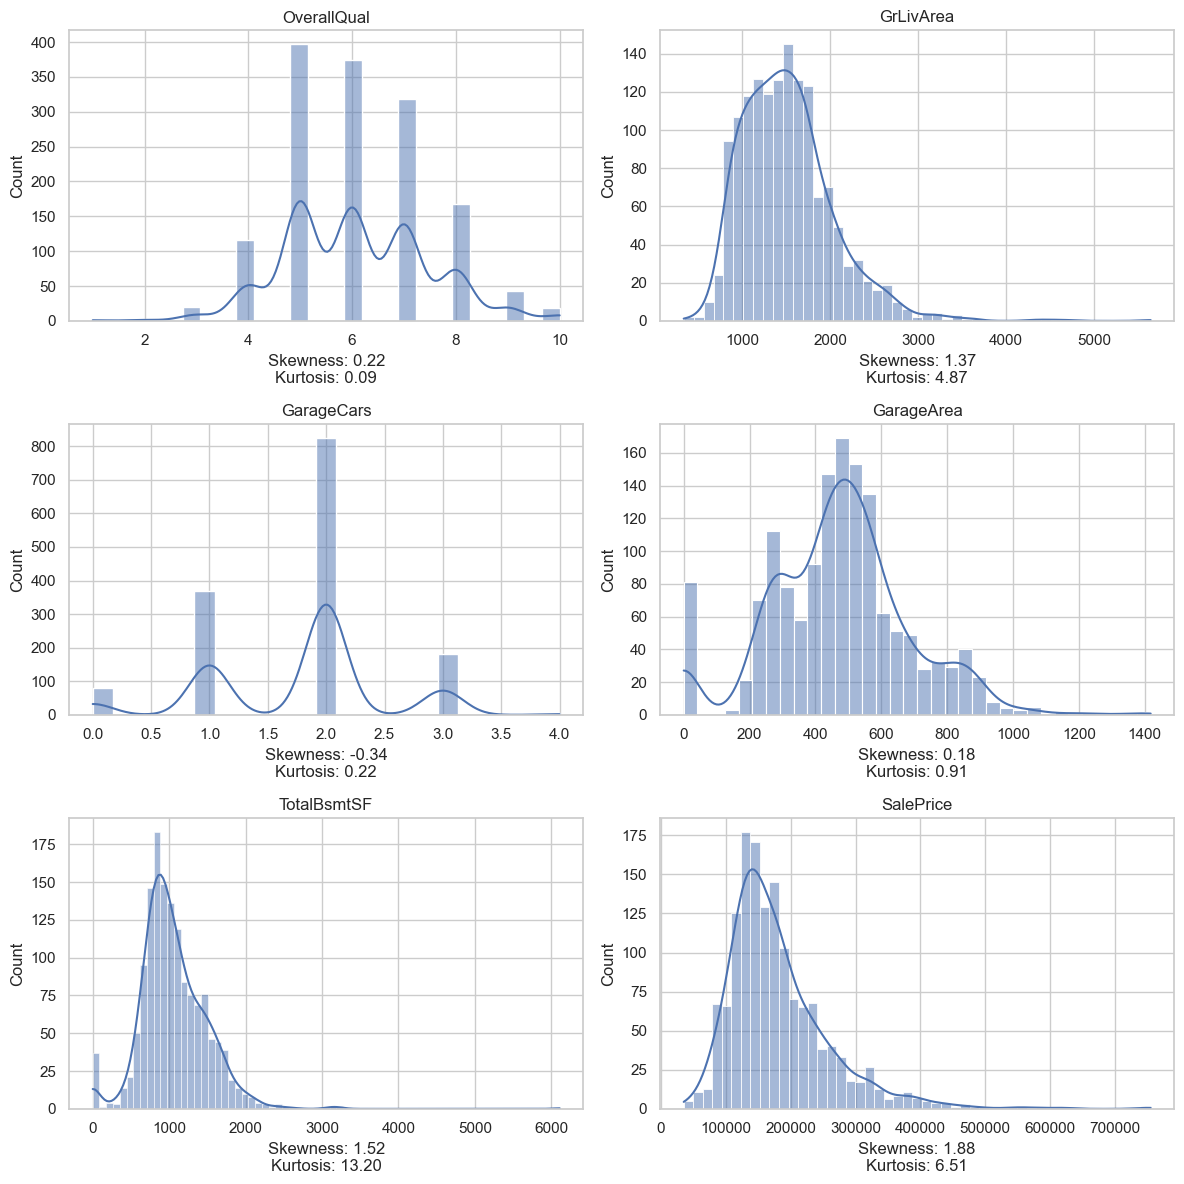

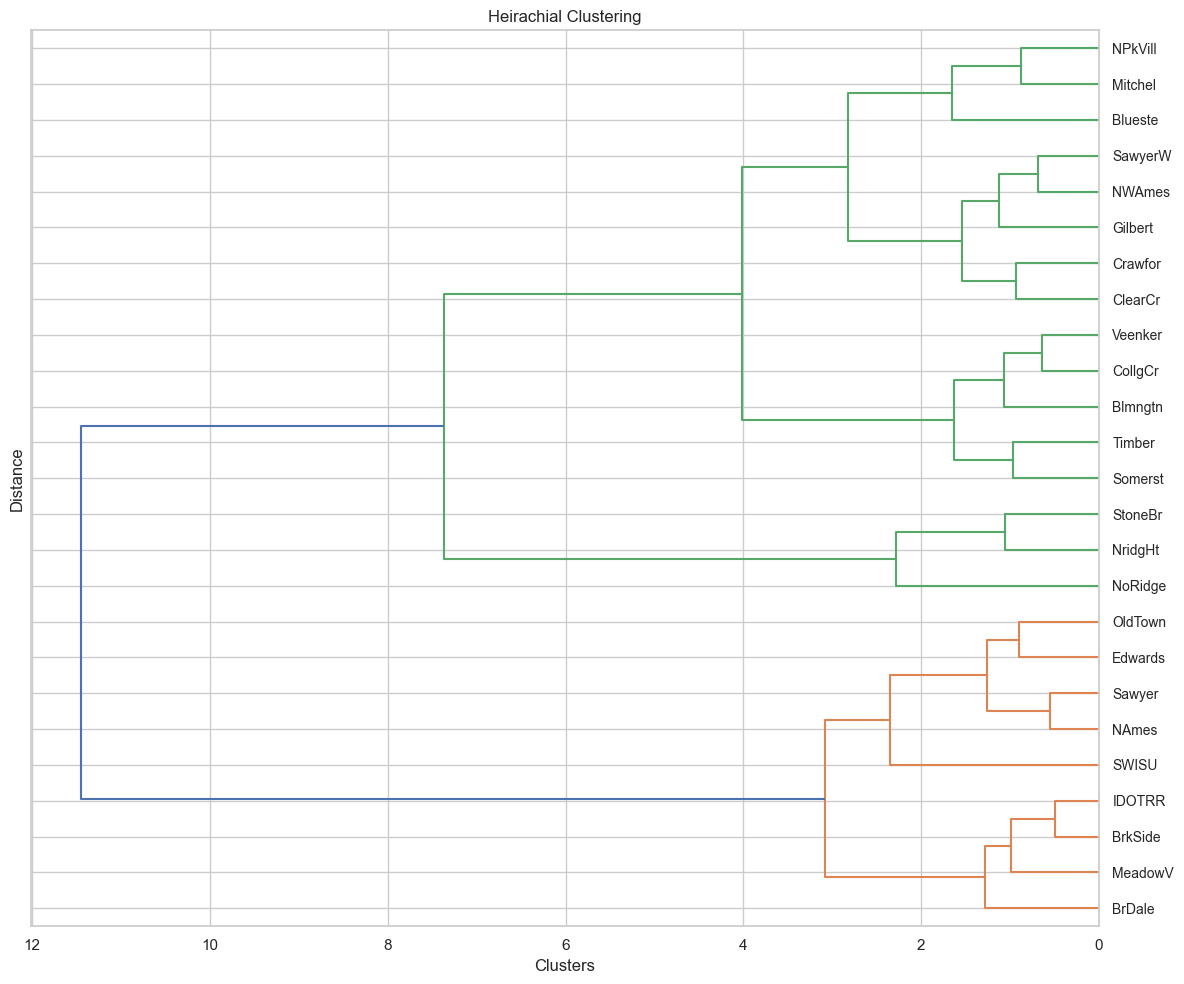

In [44]:
# Part 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Task 1: Initial EDA
# 1a) Summary statistics
num_instances = len(data)
num_features = len(data.columns)
num_categorical = len(data.select_dtypes(include=['object']).columns)
num_numerical = len(data.select_dtypes(include=['int64', 'float64']).columns)

# 1b) Correlation with SalePrice

numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

print("Data Summary:\n")

print(f"Number of instances: {num_instances}")
print(f"Number of features: {num_features}")
print(f"Number of categorical features: {num_categorical}")
print(f"Number of numerical features: {num_numerical}\n")

print("----------------------------------------------------\n")

for feature in top_corr_features.index:
    correlation_value = correlation_matrix.loc[feature, "SalePrice"]
    print(f"Correlation between {feature} and SalePrice: {correlation_value:.2f}")

print("\n----------------------------------------------------\n")

missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

# Count the number of features with missing values
num_features_with_missing = missing_percentage[missing_percentage > 0].count()

# Print a summary of missing information
print(f"Number of features with missing values: {num_features_with_missing}")
print("Missing values summary:\n")
for feature, percent in zip(missing_values.index, missing_percentage):
    if percent > 0:
        print(f"{feature}: {percent:.2f}% missing")
        
print("\n----------------------------------------------------\n")

# Handle missing values and calculate correlations
try:
    data_numeric = data[numeric_columns]
    data_numeric = data_numeric.dropna()  # Drop rows with missing values
    correlation_matrix = data_numeric.corr()
    corr_with_saleprice = correlation_matrix["SalePrice"].sort_values(ascending=False)
    top_corr_features = corr_with_saleprice[1:6]  # Exclude SalePrice itself


except ValueError as e:
    print("Error during correlation calculation:", e)
    top_corr_features = None


# Continue only if none
if top_corr_features is not None:
    # 1c) Plot histograms for top correlated features and SalePrice
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 12))  # Increase figure size
    features_to_plot = top_corr_features.index.tolist() + ["SalePrice"]  # Include SalePrice
    num_features_to_plot = len(features_to_plot)
    
    for i, feature in enumerate(features_to_plot):
        plt.subplot(3, 2, i+1)
        sns.histplot(data[feature], kde=True)
        plt.title(feature)
        
        # Calculate skewness and kurtosis
        feature_skewness = skew(data[feature])
        feature_kurtosis = kurtosis(data[feature])
        plt.xlabel(f"Skewness: {feature_skewness:.2f}\nKurtosis: {feature_kurtosis:.2f}")
        
    plt.tight_layout()
    plt.show()

    # 1d) Missing values
    missing_values = data.isnull().sum()
    missing_percent = (missing_values / num_instances) * 100

# Hierarchical Clustering

num_features_to_cluster = data[list(top_corr_features.index)]

# Handle missing values in the selected features
num_features_to_cluster = num_features_to_cluster.dropna()

# Scale the features before clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_features_to_cluster)

# Apply Hierarchical Clustering
neighbourhood_cluster_data = data.groupby('Neighborhood')[list(top_corr_features.index)].mean()  # Use mean for numerical features
neighbourhood_cluster_scaled = StandardScaler().fit_transform(neighbourhood_cluster_data)
neighbourhood_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
neighbourhood_cluster_labels = neighbourhood_clustering.fit_predict(neighbourhood_cluster_scaled)

# Plot dendrogram with neighbourhood-based clustering
plt.figure(figsize=(12, 10))
dendrogram_data = dendrogram(linkage(neighbourhood_cluster_scaled, method='ward'), orientation='left', labels=neighbourhood_cluster_data.index, leaf_font_size=10)
plt.title('Heirachial Clustering')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.tight_layout()  # Ensure labels are fully visible
plt.show()

In [47]:
# Part 2

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Data Preprocessing
data = pd.read_csv("A2_Data/House_Price.csv")
imputer = SimpleImputer(strategy='mean')  # Replace missing values with mean
data.fillna(value={'Alley': 'NA', 'MasVnrType': 'None', 'MasVnrArea': 0, 'BsmtQual': 'NA', 
                   'BsmtCond': 'NA', 'BsmtExposure': 'NA', 'BsmtFinType1': 'NA', 'BsmtFinType2': 'NA',
                   'FireplaceQu': 'NA', 'GarageType': 'NA', 'GarageYrBlt': 0, 'GarageFinish': 'NA', 
                   'GarageQual': 'NA', 'GarageCond': 'NA', 'PoolQC': 'NA', 'Fence': 'NA', 
                   'MiscFeature': 'NA'}, inplace=True)
label_encoder = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])
X = data.drop(columns=['SalePrice', 'Id'])
y = data['SalePrice']
X_imputed = imputer.fit_transform(X)  # Impute missing values
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=309)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save processed training and test data to CSV files
X_train_processed = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_processed.to_csv("X_train_processed.csv", index=False)
X_test_processed = pd.DataFrame(X_test_scaled, columns=X.columns)
X_test_processed.to_csv("X_test_processed.csv", index=False)

# Dimensionality Reduction
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=5)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

# Linear Regression and Ridge Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)
y_train_pred_linear = linear_reg.predict(X_train_scaled)
y_test_pred_linear = linear_reg.predict(X_test_scaled)
ridge_reg = Ridge(alpha=0.5)
ridge_reg.fit(X_train_scaled, y_train)
y_train_pred_ridge = ridge_reg.predict(X_train_scaled)
y_test_pred_ridge = ridge_reg.predict(X_test_scaled)
mse_train_linear = mean_squared_error(y_train, y_train_pred_linear)
mse_test_linear = mean_squared_error(y_test, y_test_pred_linear)
mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)
print(f"Linear Regression: Train MSE = {mse_train_linear:.2f}, Test MSE = {mse_test_linear:.2f}")
print(f"Ridge Regression: Train MSE = {mse_train_ridge:.2f}, Test MSE = {mse_test_ridge:.2f}")

# Random Forest Regression
random_forest = RandomForestRegressor()
random_forest.fit(X_train_scaled, y_train)
y_train_pred_rf = random_forest.predict(X_train_scaled)
y_test_pred_rf = random_forest.predict(X_test_scaled)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
print(f"Random Forest Regression: Train MSE = {mse_train_rf:.2f}, Test MSE = {mse_test_rf:.2f}")

Linear Regression: Train MSE = 945813909.03, Test MSE = 1019562033119407876897505280.00
Ridge Regression: Train MSE = 946098699.15, Test MSE = 1147771239.08
Random Forest Regression: Train MSE = 164117000.24, Test MSE = 655358306.17
